In [71]:
import os
os.chdir("/Users/Mohammed/Desktop/SMALLMOL_MD")

In [127]:
import pandas as pd

# Load the full merged dataset
df = pd.read_csv("MD_ADMET_RDKIT_FS.csv")

# Count molecules per dataset
dataset_counts = df["dataset"].value_counts()

# Display results
print("📊 Dataset Sizes:")
print(dataset_counts)

📊 Dataset Sizes:
dataset
cyp3a4_substrate_carbonmangels    173
cyp2c9_substrate_carbonmangels    172
cyp2d6_substrate_carbonmangels    172
bioavailability_ma                149
half_life_obach                   128
bbb_martins                       122
lipophilicity_astrazeneca         105
solubility_aqsoldb                 97
clearance_hepatocyte_az            76
Name: count, dtype: int64


bioavailability_ma — N=149 | RDKit=129 | MD-only=22 | RDKit+MD=151
Train: 119 (pos=99, neg=20) | Test: 30 (pos=25, neg=5)
▶ RDKit only: F1=0.909 | Acc=0.833 | ROC-AUC=0.304 | best={'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': None, 'clf__bootstrap': True}
▶ RDKit + MD: F1=0.926 | Acc=0.867 | ROC-AUC=0.512 | best={'clf__n_estimators': 600, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': None, 'clf__bootstrap': True}


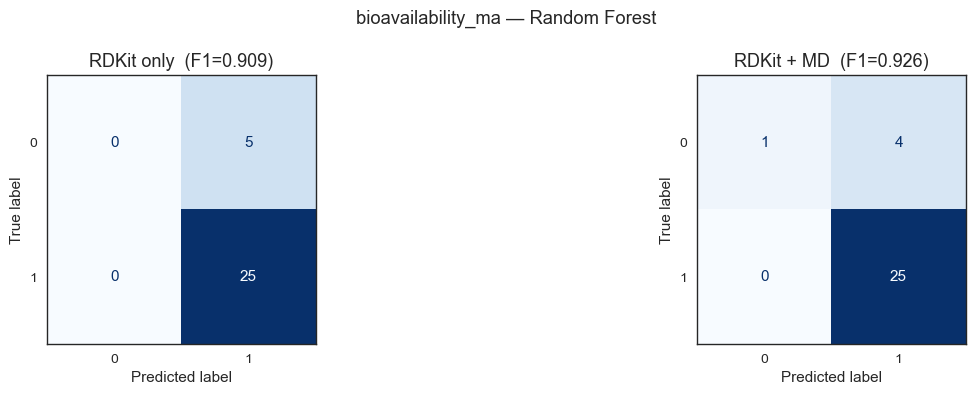

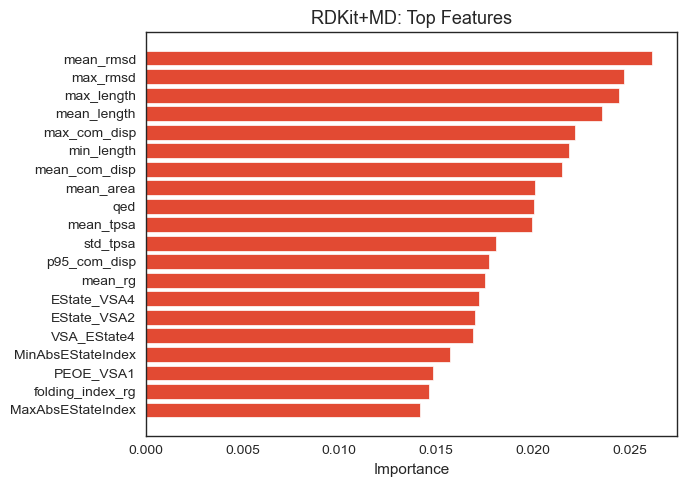


Saved metrics → bioavailability_ma_rf_holdout_summary.csv
Saved JSON → bioavailability_ma_rf_holdout_summary.json


In [375]:
# === Random Forest classification on RDKit / MD / RDKit+MD ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# ---------------------------
# Config
# ---------------------------
DATA_FILE    = "MD_ADMET_RDKIT_FS.csv"   # change if needed
DATASET_NAME = "bioavailability_ma"
TEST_SIZE    = 0.2
RANDOM_STATE = 42

# explicit meta + MD columns
meta_cols = ["ID", "smiles", "dataset", "Y"]
md_cols = [
    "mean_length", "std_length", "min_length", "max_length",
    "mean_rg", "std_rg",
    "mean_area", "std_area",
    "mean_tpsa", "std_tpsa",
    "convergence_score",
    "folding_index_rg", "folding_index_l",
    "flexibility_index",
    "mean_com_disp", "max_com_disp", "p95_com_disp",
    "mean_rmsd", "max_rmsd",
    "diff_coeff", "hbonds_mean", "hbonds_std"
]

# RF hyperparameter space
rf_param_space = {
    "clf__n_estimators": [100, 200, 300, 400, 500, 600],
    "clf__max_depth": [None, 6, 8, 12],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__bootstrap": [True, False],
}

# ---------------------------
# Load + slice
# ---------------------------
df = pd.read_csv(DATA_FILE)
df_d = df[df["dataset"] == DATASET_NAME].copy()
df_d = df_d[df_d["Y"].isin([0, 1])].dropna(subset=["Y"])
y_all = df_d["Y"].astype(int)

missing = [c for c in md_cols if c not in df_d.columns]
if missing:
    raise ValueError(f"Missing MD columns: {missing}")

# Build feature sets
X_rdkit_all   = df_d.drop(columns=meta_cols + md_cols, errors="ignore").select_dtypes(include=[np.number])
X_md_all      = df_d.drop(columns=meta_cols, errors="ignore").select_dtypes(include=[np.number])

print(f"{DATASET_NAME} — N={len(df_d)} | RDKit={X_rdkit_all.shape[1]} | MD-only={X_md_only_all.shape[1]} | RDKit+MD={X_md_all.shape[1]}")

# ---------------------------
# Train / test split (stratified)
# ---------------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
(tr_idx, te_idx), = sss.split(X_rdkit_all, y_all)

def split(X):
    return X.iloc[tr_idx].reset_index(drop=True), X.iloc[te_idx].reset_index(drop=True)

Xr_tr, Xr_te = split(X_rdkit_all)
Xm_tr, Xm_te = split(X_md_all)
y_tr = y_all.iloc[tr_idx].reset_index(drop=True)
y_te = y_all.iloc[te_idx].reset_index(drop=True)

print(f"Train: {len(y_tr)} (pos={int((y_tr==1).sum())}, neg={int((y_tr==0).sum())}) | "
      f"Test: {len(y_te)} (pos={int((y_te==1).sum())}, neg={int((y_te==0).sum())})")

# ---------------------------
# Helper: tune, fit, eval (Random Forest)
# ---------------------------
def tune_fit_eval_rf(X_tr, y_tr, X_te, y_te, label):
    # pipeline: impute NaNs → RF
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("clf", RandomForestClassifier(
            n_jobs=-1,
            random_state=RANDOM_STATE,
            class_weight="balanced"  # helps with imbalance
        ))
    ])

    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    search = RandomizedSearchCV(
        pipe,
        param_distributions=rf_param_space,
        n_iter=25,
        scoring="f1",
        cv=inner_cv,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE,
        refit=True
    )
    search.fit(X_tr, y_tr)
    best = search.best_estimator_

    # predictions
    prob = best.predict_proba(X_te)[:, 1]
    y_pred = (prob >= 0.5).astype(int)

    f1  = f1_score(y_te, y_pred)
    acc = accuracy_score(y_te, y_pred)
    try:
        auc = roc_auc_score(y_te, prob)
    except ValueError:
        auc = np.nan

    print(f"▶ {label}: F1={f1:.3f} | Acc={acc:.3f} | ROC-AUC={auc:.3f} | best={search.best_params_}")
    return best, y_pred, prob, f1, acc, auc

# ---------------------------
# Train all three (in requested order)
# ---------------------------
best_r,  yhat_r,  proba_r,  f1_r,  acc_r,  auc_r  = tune_fit_eval_rf(Xr_tr,  y_tr, Xr_te,  y_te, "RDKit only")
best_m,  yhat_m,  proba_m,  f1_m,  acc_m,  auc_m  = tune_fit_eval_rf(Xm_tr,  y_tr, Xm_te,  y_te, "RDKit + MD")

# ---------------------------
# Confusion matrices
# ---------------------------
plt.figure(figsize=(15, 4))
for i, (preds, title) in enumerate([
    (yhat_r,  f"RDKit only  (F1={f1_r:.3f})"),
    (yhat_m,  f"RDKit + MD  (F1={f1_m:.3f})"),
]):
    ax = plt.subplot(1, 2, i+1)
    cm = confusion_matrix(y_te, preds, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(ax=ax, values_format="d", cmap="Blues", colorbar=False)
    ax.set_title(title)
plt.suptitle(f"{DATASET_NAME} — Random Forest")
plt.tight_layout()
plt.show()

# ---------------------------
# Feature importances (top 20)
# ---------------------------
def plot_importances(model, X_cols, title, topn=10):
    # model is Pipeline; the RF is model.named_steps["clf"]
    rf = model.named_steps["clf"]
    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1][:topn]
    names = np.array(X_cols)[idx]
    vals = importances[idx]

    plt.figure(figsize=(7, 5))
    plt.barh(names[::-1], vals[::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_importances(best_m,  Xm_te.columns,  "RDKit+MD: Top Features",    topn=20)

# ---------------------------
# (Optional) Save a compact summary
# ---------------------------
summary = pd.DataFrame({
    "set": ["RDKit", "RDKit+MD"],
    "F1":  [f1_r, f1_m],
    "Acc": [acc_r, acc_m],
    "AUC": [auc_r, auc_m],
})
#summary.to_csv(f"{DATASET_NAME}_rf_holdout_summary.csv", index=False)
print("\nSaved metrics →", f"{DATASET_NAME}_rf_holdout_summary.csv")

RUN_LABEL = "rf_holdout20_rs42"
summary.assign(run_label=RUN_LABEL).to_json(
    f"{DATASET_NAME}_rf_holdout_summary.json", orient="records", indent=2
)
print("Saved JSON →", f"{DATASET_NAME}_rf_holdout_summary.json")

bioavailability_ma — N=149 | RDKit=129 | MD-only=22 | RDKit+MD=151
Train: 119 (pos=99, neg=20) | Test: 30 (pos=25, neg=5)
▶ RDKit only: F1=0.846 | Acc=0.733 | ROC-AUC=0.408 | best_params={'subsample': 0.9, 'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
▶ RDKit + MD: F1=0.863 | Acc=0.767 | ROC-AUC=0.456 | best_params={'subsample': 0.9, 'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


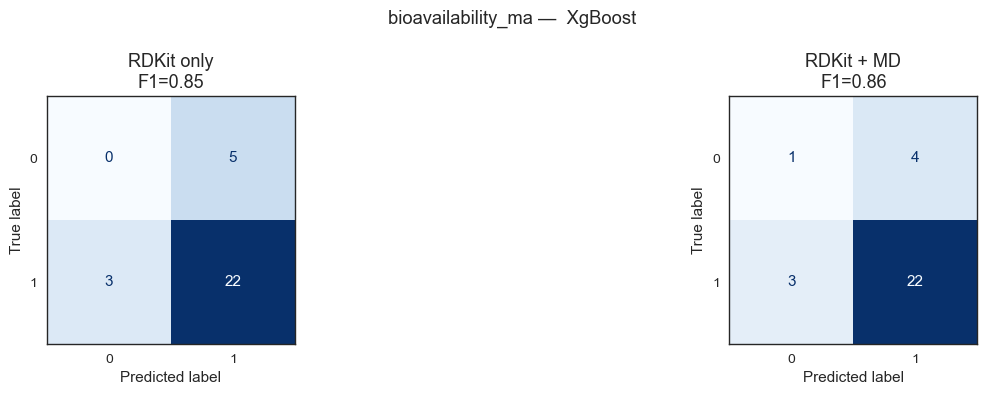

▶ RDKit + MD (SHAP-selected): F1=0.885 | Acc=0.800 | ROC-AUC=0.416 | best_params={'subsample': 0.9, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

Saved: bioavailability_ma_holdout20_rs42_summary.json, bioavailability_ma_holdout20_rs42_test_probas.csv, bioavailability_ma_holdout20_rs42_rdkit_md_shap_importance.csv


In [419]:
# === 20% stratified hold-out with nested CV and SHAP feature selection ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# ---------------------------
# Config
# ---------------------------
DATA_FILE = "MD_ADMET_RDKIT_FS.csv"
DATASET_NAME = "bioavailability_ma"
RANDOM_STATE = 42
TEST_SIZE = 0.2

param_grid = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 1000, 1200],
    "max_depth": [4, 5, 6, 7, 8, 10],
    "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
}

meta_cols = ["ID", "smiles", "dataset", "Y"]

md_cols = [
    "mean_length", "std_length", "min_length", "max_length",
    "mean_rg", "std_rg",
    "mean_area", "std_area",
    "mean_tpsa", "std_tpsa",
    "convergence_score",
    "folding_index_rg", "folding_index_l",
    "flexibility_index",
    "mean_com_disp", "max_com_disp", "p95_com_disp",
    "mean_rmsd", "max_rmsd",
    "diff_coeff", "hbonds_mean", "hbonds_std"
]

# ---------------------------
# Load + slice dataset
# ---------------------------
df = pd.read_csv(DATA_FILE)
df_d = df[df["dataset"] == DATASET_NAME].copy()
df_d = df_d[df_d["Y"].isin([0, 1])].dropna(subset=["Y"])
y_all = df_d["Y"].astype(int)

missing = [c for c in md_cols if c not in df_d.columns]
if missing:
    raise ValueError(f"Missing MD columns in data: {missing}")

X_rdkit_all   = df_d.drop(columns=meta_cols + md_cols, errors="ignore").select_dtypes(include=[np.number])
X_md_all      = df_d.drop(columns=meta_cols, errors="ignore").select_dtypes(include=[np.number])

print(f"{DATASET_NAME} — N={len(df_d)} | RDKit={X_rdkit_all.shape[1]} | MD-only={X_md_only_all.shape[1]} | RDKit+MD={X_md_all.shape[1]}")

# ---------------------------
# Train/test split
# ---------------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
(tr_idx, te_idx), = sss.split(X_rdkit_all, y_all)

def split_by_index(X):
    return X.iloc[tr_idx].reset_index(drop=True), X.iloc[te_idx].reset_index(drop=True)

Xr_tr, Xr_te = split_by_index(X_rdkit_all)
Xm_tr, Xm_te = split_by_index(X_md_all)
y_tr, y_te = y_all.iloc[tr_idx].reset_index(drop=True), y_all.iloc[te_idx].reset_index(drop=True)

print(f"Train: {len(y_tr)} (pos={int((y_tr==1).sum())}, neg={int((y_tr==0).sum())}) | "
      f"Test: {len(y_te)} (pos={int((y_te==1).sum())}, neg={int((y_te==0).sum())})")

# ---------------------------
# Training + Evaluation
# ---------------------------
def tune_fit_eval(X_tr, y_tr, X_te, y_te, label):
    pos = max(int((y_tr == 1).sum()), 1)
    neg = int((y_tr == 0).sum())
    spw = neg / pos

    base = XGBClassifier(
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scale_pos_weight=spw,
        tree_method="hist",
    )
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    search = RandomizedSearchCV(
        base,
        param_distributions=param_grid,
        n_iter=15,
        scoring="f1",
        cv=inner_cv,
        n_jobs=-1,
        refit=True,
        verbose=0,
        random_state=RANDOM_STATE
    )
    search.fit(X_tr, y_tr)
    best = search.best_estimator_

    best.fit(X_tr, y_tr)
    proba = best.predict_proba(X_te)[:, 1]
    y_pred = (proba >= 0.5).astype(int)

    f1  = f1_score(y_te, y_pred)
    acc = accuracy_score(y_te, y_pred)
    try:
        auc = roc_auc_score(y_te, proba)
    except ValueError:
        auc = np.nan

    print(f"▶ {label}: F1={f1:.3f} | Acc={acc:.3f} | ROC-AUC={auc:.3f} | best_params={search.best_params_}")
    return best, y_pred, proba, f1, acc, auc, search.best_params_

# Train all three
best_r,  yhat_r,  proba_r,  f1_r,  acc_r,  auc_r,  p_r   = tune_fit_eval(Xr_tr, y_tr, Xr_te, y_te, "RDKit only")
best_m,  yhat_m,  proba_m,  f1_m,  acc_m,  auc_m,  p_m   = tune_fit_eval(Xm_tr, y_tr, Xm_te, y_te, "RDKit + MD")

# ---------------------------
# Confusion matrices
# ---------------------------
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for ax, preds, title in [
    (axs[0], yhat_r,  f"RDKit only\nF1={f1_r:.2f}"),
    (axs[1], yhat_m,  f"RDKit + MD\nF1={f1_m:.2f}"),
]:
    cm = confusion_matrix(y_te, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(ax=ax, values_format="d", cmap="Blues", colorbar=False)
    ax.set_title(title)
plt.suptitle(f"{DATASET_NAME} —  XgBoost")
plt.tight_layout()
plt.show()

# ---------------------------
# SHAP Feature Selection on RDKit + MD
# ---------------------------
explainer = shap.Explainer(best_m, Xm_tr, feature_names=Xm_tr.columns)
shap_values = explainer(Xm_tr)

# Summary plot
shap.summary_plot(
    shap_values, Xm_tr,
    max_display=10, plot_type="dot", show=False
)

# Adjust figure size (width ↓, height same or slightly taller)
plt.gcf().set_size_inches(5, 5)  # width=6 inches, height=5 inches

# Add custom title
plt.title("Bioavailability", fontsize=14, pad=20, fontweight="bold")

for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")


# Layout & save
plt.tight_layout()
plt.savefig("Bioavailability_shap_top10.png", dpi=300)
plt.close()
# Rank features
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({"feature": Xm_tr.columns, "mean_abs_shap": mean_abs_shap})
shap_df = shap_df.sort_values("mean_abs_shap", ascending=False)
top_k = 20
top_features = shap_df["feature"].head(top_k).tolist()

# Retrain using top SHAP-selected features
Xm_tr_top = Xm_tr[top_features]
Xm_te_top = Xm_te[top_features]
best_m_shap, yhat_m_shap, proba_m_shap, f1_m_shap, acc_m_shap, auc_m_shap, p_m_shap = \
    tune_fit_eval(Xm_tr_top, y_tr, Xm_te_top, y_te, "RDKit + MD (SHAP-selected)")

# ---------------------------
# Save outputs
# ---------------------------
out_prefix = f"{DATASET_NAME}_holdout{int(TEST_SIZE*100)}_rs{RANDOM_STATE}"
pd.DataFrame({
    "set": ["RDKit", "RDKit+MD", "RDKit+MD (SHAP-selected)"],
    "F1":  [f1_r, f1_m, f1_m_shap],
    "Acc": [acc_r, acc_m, acc_m_shap],
    "AUC": [auc_r, auc_m, auc_m_shap],
    "best_params": [p_r, p_m, p_m_shap],
}).to_json(f"{out_prefix}_summary.json", orient="records", indent=2)

pd.DataFrame({"y_true": y_te, "proba_rdkit": proba_r, "proba_mdonly": proba_mo, "proba_rdkit_md": proba_m,
              "proba_rdkit_md_shap": proba_m_shap}).to_csv(f"{out_prefix}_test_probas.csv", index=False)

#shap_df.to_csv(f"{out_prefix}_rdkit_md_shap_importance.csv", index=False)

print("\nSaved:",
      f"{out_prefix}_summary.json,",
      f"{out_prefix}_test_probas.csv,",
      f"{out_prefix}_rdkit_md_shap_importance.csv")